# INSEE’s premises

In [1]:
import geopandas
import re
import pandas as pd
import pyproj
from shapely.ops import transform

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib, descartes

from pynsee.sirene import search_sirene
from pynsee.geodata import get_geodata_list, get_geodata

In [3]:
import logging
import sys
logging.basicConfig(stream=sys.stdout,
                    level=logging.INFO, 
                    format="%(message)s")

In [4]:
# Subscribe to api.insee.fr and get your credentials!
# Save your credentials with init_conn function :
# from pynsee.utils.init_conn import init_conn
# init_conn(sirene_key="my_sirene_key")

# Beware : any change to the keys should be tested after having cleared the cache
# Please do : from pynsee.utils import clear_all_cache; clear_all_cache()"

In [5]:
variable = ["denominationUniteLegale", 'sigleUniteLegale', 'categorieJuridiqueUniteLegale']

insee_pattern = "INSTITUT NATIONAL DE LA STATISTIQUE ET DES ETUDES ECONOMIQUES"

pattern = [insee_pattern, 'INSEE', '7120']
# 7120 : Service central d'un ministère

data = search_sirene(variable = variable, pattern = pattern, kind="siret")

1 - Getting data: 100%|██████████| 56/56 [00:00<00:00, 390.78it/s]

This function renders package's internal data


This function may return personal data, please check and comply with the legal framework relating to personal data protection !
Data saved:
/home/onyxia/.cache/pynsee/pynsee/acaae682614742b3fc8d1b32c8e57c06.parquet


In [6]:
df = data.get_location()

This function returns data made available by OpenStreetMap and its contributors.
Please comply with Openstreetmap's Copyright and ODbL Licence


Getting location:  44%|████▍     | 14/32 [00:13<00:17,  1.02it/s]

For at least one point, exact location has not been found, city location has been given instead


Getting location: 100%|██████████| 32/32 [00:34<00:00,  1.07s/it]


In [7]:
def _convert_polygon(geo, crs_in='EPSG:4326', crs_out='EPSG:3857'):
    
    if geo is not None:
        crsIn = pyproj.CRS(crs_in)
        crsOut = pyproj.CRS(crs_out)

        project = pyproj.Transformer.from_crs(crsIn, crsOut, always_xy=True).transform
        geo_converted = transform(project, geo)

        return geo_converted

# convert openstreetmap data from crs 4326 to crs 3857
df['geometry'] = df['geometry'].apply(lambda x: _convert_polygon(x))

df["crsCoord"] = 'EPSG:3857'

# move overseas departement closer to metropolitan France
df = df.translate()

# add a zoom on ile de France region
df = df.zoom()

Finding departement: 100%|██████████| 32/32 [00:00<00:00, 1197.06it/s]


In [8]:
gdf = geopandas.GeoDataFrame(df).set_crs('EPSG:3857')
gdf = gdf.reset_index(drop=True)

for i in range(len(gdf.index)):
    gdf.loc[i,'name'] = str(i+1) + ' - ' + gdf.loc[i,'enseigne1Etablissement']
    gdf.loc[i,'i'] = i + 1
    
# cleaning
gdf = gdf[~gdf.geometry.isnull()]

In [9]:
geodataList =  get_geodata_list()
mapdep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')

# move overseas departement closer to metropolitan France
mapdep = mapdep.translate()
# add a zoom on ile de France region
mapdep = mapdep.zoom()

Data saved:
/home/onyxia/.cache/pynsee/pynsee/e879822687bab4b12f23762b5d56742b.parquet


In [10]:
# conversion to geopandas df
mapdepgeo = geopandas.GeoDataFrame(mapdep).set_crs("EPSG:3857")
mapdepgeo.head()

,id,nom_m,nom,insee_dep,insee_reg,geometry,crsCoord
0,DEPARTEM_GLP_00000000001,GUADELOUPE,Guadeloupe,971,01,"MULTIPOLYGON (((-739144.768 6296095.811, -7391...",EPSG:3857
1,DEPARTEM_MTQ_00000000001,MARTINIQUE,Martinique,972,02,"MULTIPOLYGON (((-756952.991 6056785.106, -7569...",EPSG:3857
2,DEPARTEM_REU_00000000001,LA REUNION,La Réunion,974,04,"MULTIPOLYGON (((-807376.954 5867965.281, -8072...",EPSG:3857
3,DEPARTEM_GUF_00000000001,GUYANE,Guyane,973,03,"MULTIPOLYGON (((-650783.613 5681770.336, -6507...",EPSG:3857
4,DEPARTEM_MYT_00000000001,MAYOTTE,Mayotte,976,06,"MULTIPOLYGON (((-553726.624 5453062.725, -5537...",EPSG:3857


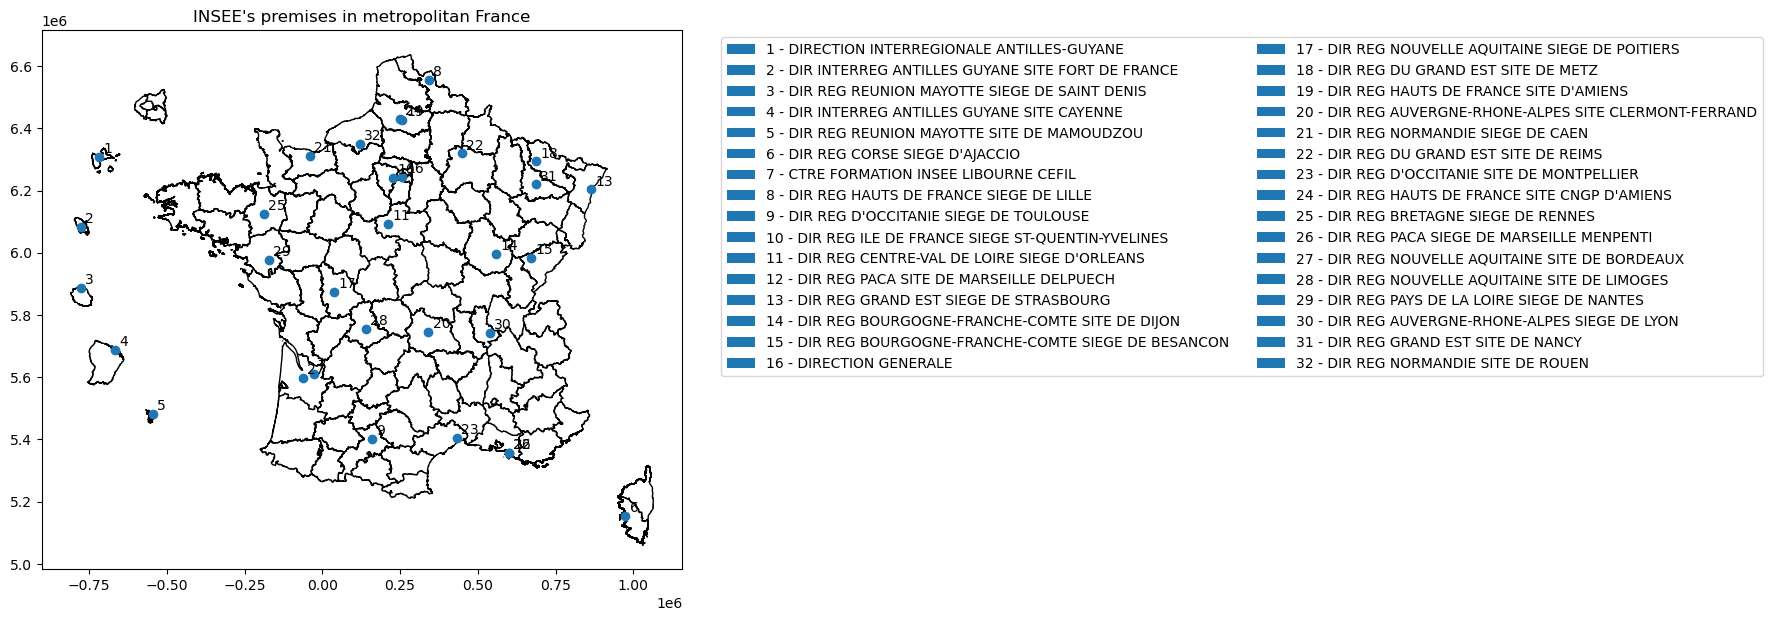

In [11]:
# plot
ax = mapdepgeo.plot(color='white', edgecolor='black', figsize = (15,7))

gdf.plot(ax=ax)
plt.title("INSEE's premises in metropolitan France")

for x, y, i, label in zip(gdf.geometry.x, gdf.geometry.y, gdf.i, gdf.name):
    ax.annotate(int(i), xy=(x, y), xytext=(3, 3), textcoords="offset points")

legends = [mpatches.Patch(label=f) for f in gdf.name]
plt.legend(handles=legends, ncol=2, bbox_to_anchor=(1.05, 1))
plt.show()